In [1]:
%config Completer.use_jedi = False
import matplotlib
import pickle
import platform
import glob
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import sklearn.preprocessing as skp
import sklearn.metrics as skm
import sklearn.model_selection as skms
import sklearn.decomposition as skd
import tensorflow as tf
from matplotlib import gridspec
from timeit import default_timer as timer

def rcparams(r=0.5):
    matplotlib.rcParams['mathtext.fontset'] = 'stix'
    matplotlib.rcParams['font.family'] = 'STIXGeneral'
    matplotlib.rcParams['font.size'] = 25 * r
    matplotlib.rcParams['xtick.labelsize'] = 20 * r
    matplotlib.rcParams['ytick.labelsize'] = 20 * r
    matplotlib.rcParams['axes.labelsize'] = 25 * r
    matplotlib.rcParams['legend.title_fontsize'] = 17 * r
    matplotlib.rcParams['legend.fontsize'] = 17 * r
    matplotlib.rcParams['axes.axisbelow'] = True
    matplotlib.rcParams['figure.figsize'] = [6 * r, 6 * r]

rcparams()

# format axis
def format_axis(ax):
    from matplotlib.ticker import (AutoMinorLocator)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(which='both', width=2)
    ax.tick_params(which='major', length=6)
    ax.tick_params(which='minor', length=3)
    ax.locator_params(axis='x', nbins=5)
    ax.locator_params(axis='y', nbins=5)
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(1.5)

np.set_printoptions(precision=4)

### Define directories

In [3]:
if platform.system() == 'Darwin':
    PLOT_DIR = '/Users/sjiang87/machinelearning2/plastic/result/figure/2nd/'
    RESULT_DIR = '/Users/sjiang87/machinelearning2/plastic/result/2nd/'
    DATA_DIR = '/Users/sjiang87/plastic/data/'
elif platform.system() == 'Windows':
    PLOT_DIR = 'D:/machinelearning2/plastic/result/figure/2nd/'
    RESULT_DIR = 'D:/machinelearning2/plastic/result/2nd/'
    DATA_DIR = 'D:/plastic/data/'

### PCA

In [15]:
name = ['ABS/PC', 'ABS', 'HIPS', 'PA12', 'PE', 'PET', 'PLA', 'PMMA', 'POM', 'PP/PE/PS', 'PP', 'PS', 'PVC', 'PC']
colors = ['tab:gray', 'tab:red', 'tab:blue', 'tab:orange', 'tab:green', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:olive', 'tab:cyan', 'darkgreen', 'gold', 'tomato', 'violet', 'teal']

with open(DATA_DIR + 'fast_with_pc.pickle', "rb") as f:
    x = pickle.load(f)
    y = pickle.load(f)
x = skp.StandardScaler().fit_transform(x.T).T
xpca = skd.PCA(n_components=2, whiten=True).fit_transform(x)

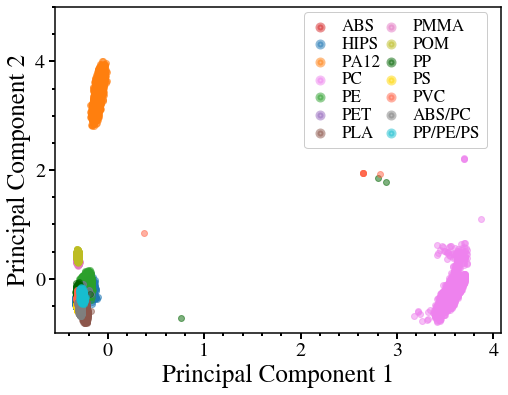

In [19]:
rcparams(1)
fig, ax = plt.subplots(figsize=(8, 6))
for i in [1, 2, 3, 13, 4, 5, 6, 7, 8, 10, 11, 12, 0, 9]:
    idx = np.where(y == i)[0]
    ax.scatter(xpca[idx, 0], xpca[idx, 1], alpha=0.5, label=name[i], c=colors[i])
#ax.set_xlim([-0.5, 0.5])
ax.set_ylim([-1, 5])
leg = plt.legend(ncol=2, bbox_to_anchor=(0.54, 1.01), loc='upper left', columnspacing=0.1, handlelength=1.0,
                 labelspacing=0.1)
for legobj in leg.legendHandles:
    legobj.set_linewidth(4.0)
leg.get_frame().set_alpha(None)
leg.get_frame().set_facecolor((0, 0, 0, 0.0))
ax.set_xlabel(r'Principal Component 1')
ax.set_ylabel(r'Principal Component 2')
format_axis(ax)
plt.savefig(PLOT_DIR + 'pca.svg', bbox_inches='tight')
plt.savefig(PLOT_DIR + 'pca.png', bbox_inches='tight', dpi=300)
plt.show()


### 1D CNN results

In [4]:
%%time 
def get_result(image_size):
    """
    Get the best accuracy with various hyperparameter combinations.
    :param image_size: int, image size, 0 is 1D, 25, 50, 75, 100 are 2D.
    :return: 
    """
    # minimum accuracy is set to 0
    acc_best = 0
    # 3 choices of learning rates
    for learning_rate in [0.0005, 0.001, 0.005]:
        # 3 choices of batch sizes
        for batch_size in [64, 128, 256]:
            # 2 choices of model checkpoint monitors
            for model_checkpoint in ['loss', 'acc']:
                # 3 choices of convolutional filters
                for num_filters in [16, 32, 64]:
                    # extract 5-fold cross-validation results
                    files = sorted(glob.glob(RESULT_DIR + f'fast_wtih_pc_*_{image_size}_{learning_rate}_{batch_size}_{model_checkpoint}_{num_filters}.pickle'))
                    y_true = []
                    y_pred = []
                    acc_5_fold = []
                    hist_5_fold = []
                    for file in files:
                        with open(file, 'rb') as handle:
                            y_true_temp = pickle.load(handle)
                            y_pred_temp = pickle.load(handle)
                            hist = pickle.load(handle)
                        # argmax of the result
                        y_true_temp = np.argmax(y_true_temp, axis=1)
                        y_true.append(y_true_temp)
                        y_pred.append(y_pred_temp)
                        acc_5_fold.append(skm.accuracy_score(y_true_temp, y_pred_temp))
                        hist_5_fold.append(hist)
                    y_true = np.ravel(y_true)
                    y_pred = np.ravel(y_pred)
                    acc = skm.accuracy_score(y_true, y_pred)
                    # output the best accuracy
                    if acc > acc_best:
                        acc_best = acc
                        name_best = files[0]
                        y_true_best = y_true
                        y_pred_best = y_pred
                        acc_mean = np.mean(acc_5_fold)
                        acc_std = np.std(acc_5_fold)
                        hist_best = hist_5_fold
    return [acc_best, acc_mean, acc_std], name_best, y_true_best, y_pred_best, hist_best


for image_size in [0, 25, 50, 75, 100]:
    acc, name, y_true, y_pred, _ = get_result(image_size=image_size)
    print(f'Image size {image_size}: {acc[0]:0.4f}, {acc[1]:0.4f} +/- {acc[2]:0.4f}')
    print(name.split('pc_1_')[-1].split('.pickle')[0])

Image size 0: 0.9997, 0.9997 +/- 0.0001
0_0.0005_256_loss_16
Image size 25: 0.9923, 0.9923 +/- 0.0002
25_0.001_64_loss_32
Image size 50: 0.9987, 0.9987 +/- 0.0003
50_0.0005_256_acc_32
Image size 75: 0.9992, 0.9992 +/- 0.0001
75_0.0005_128_loss_16
Image size 100: 0.9995, 0.9995 +/- 0.0001
100_0.0005_256_loss_32
Wall time: 5.05 s


### Other machine learning results

In [11]:
%%time
acc = np.concatenate(([0.9997, 0.9923, 0.9987, 0.9992, 0.9995], [1.0, 0.9869, 0.8208]))
print(acc)

[0.9997 0.9923 0.9987 0.9992 0.9995 1.     0.9869 0.8208]
Wall time: 0 ns


### Plot accuracy comparison

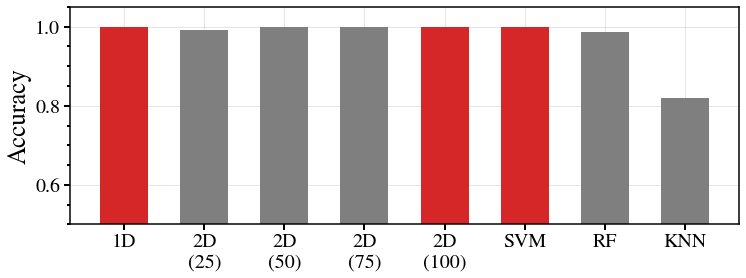

Wall time: 883 ms


In [13]:
%%time
label = ['1D',
         '2D\n' + r'(25)',
         '2D\n' + r'(50)',
         '2D\n' + r'(75)',
         '2D\n' + r'(100)',
         'SVM',
         'RF',
         'KNN']

x = np.arange(0, len(acc), 1)

rcparams(1)
fig, ax = plt.subplots(figsize=(12, 4))
ax.bar(x, acc, capsize=4, width=0.6,
       color=['tab:red'] + ['tab:gray'] * 3 + ['tab:red']*2 + ['tab:gray'] * 2)
ax.set_ylim([0.5, 1.05])
ax.grid(alpha=0.4)
format_axis(ax)
plt.xticks(x, label)
ax.tick_params(axis='x', which='minor', bottom=False)
ax.set_ylabel('Accuracy')
plt.savefig(PLOT_DIR + 'result-mix.svg', bbox_inches='tight')
plt.savefig(PLOT_DIR + 'result-mix.png', bbox_inches='tight', dpi=300)
plt.show()


### Confusion matrix 2D CNN size 100

In [6]:
%%time
def load_2d_conf():
    conf, acc = [], []
    for k in range(1, 6):
        file = glob.glob(f'../results/pickle/fast2D-2-{k}-1-100.pickle')[0]
        with open(file, 'rb') as f:
            y_true = pickle.load(f)
            y_pred = pickle.load(f)
        conf.append(skm.confusion_matrix(y_true, y_pred))
        acc.append(skm.accuracy_score(y_true, y_pred))
    conf = np.array(conf).sum(axis=0) / 5000
    
    conf = conf.T
    conf = np.flipud(conf)
    conf = pd.DataFrame(conf)
    return conf


acc, name, y_true, y_pred = get_result(image_size=100)
conf = skm.confusion_matrix(y_true, y_pred, normalize='true')
conf = conf.T
conf = np.flipud(conf)
conf = pd.DataFrame(conf)

CPU times: user 357 ms, sys: 90.4 ms, total: 447 ms
Wall time: 446 ms


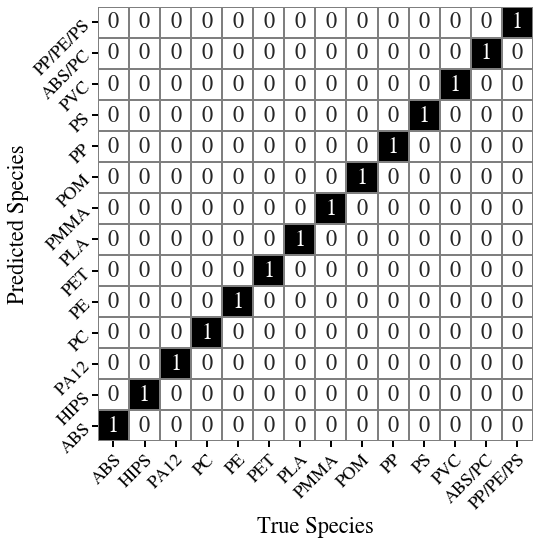

CPU times: user 2.43 s, sys: 96.2 ms, total: 2.53 s
Wall time: 2.31 s


In [8]:
%%time
name = ['ABS', 'HIPS', 'PA12', 'PC', 'PE', 'PET', 'PLA', 'PMMA', 'POM', 'PP', 'PS', 'PVC', 'ABS/PC', 'PP/PE/PS']

rcparams(0.9)
fig, ax = plt.subplots(figsize=(10, 8))
sn.heatmap(conf, annot=True, cmap="gray_r",
           square=True, vmax=1, vmin=0, fmt='0.0f', linewidths=0.25, linecolor='tab:gray', cbar=False)
ax.set_xlabel('True Species')
ax.set_ylabel('Predicted Species')
format_axis(ax)
ax.tick_params(which='minor', length=0)
ax.set_xticks(np.arange(0.5, 14, 1))
ax.set_xticklabels(name, rotation=45, rotation_mode='anchor', ha='right')
ax.set_yticks(np.arange(13.5, -0.5, -1))
ax.set_yticklabels(name, rotation=45, rotation_mode='anchor', va='center', ha='right')
plt.savefig(PLOT_DIR + 'result-confusion-matrix.svg', bbox_inches='tight')
plt.savefig(PLOT_DIR + 'result-confusion-matrix.png', bbox_inches='tight', dpi=300)
plt.show()


### Learning curves

In [5]:
hist = []
for image_size in [0, 25, 50, 75, 100]:
    _, _, _, _, hist_temp = get_result(image_size=image_size)
    hist.append(hist_temp)

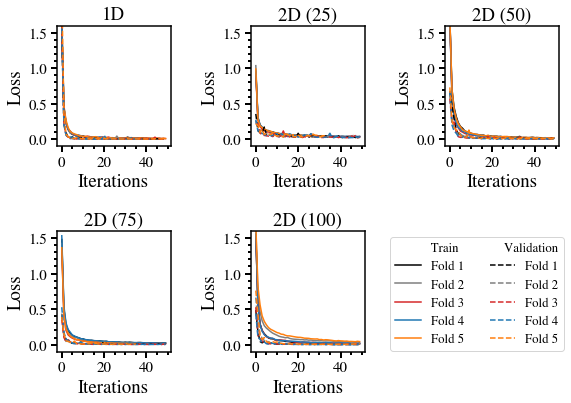

In [6]:
rcparams(0.75)
colors = ['k', 'tab:gray', 'tab:red', 'tab:blue', 'tab:orange']
titles = ['1D', '2D (25)', '2D (50)', '2D (75)', '2D (100)']
labels = [f'Fold {i}' for i in range(1, 6)]
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(9, 6))
plt.subplots_adjust(wspace=0.7, hspace=0.7)
ax = ax.ravel()
ax[5].axis('off')
for i in range(5):
    for j in range(5):
        ax[i].plot(hist[i][j]['loss'], color=colors[j], label=labels[j])
    for j in range(5):
        ax[i].plot(hist[i][j]['val_loss'], color=colors[j], ls='--', label=labels[j])
        ax[i].set_xlabel('Iterations')
        ax[i].set_ylabel('Loss')
        ax[i].set_ylim([-0.1, 1.6])
        ax[i].set_title(titles[i], fontsize=18.75)
        if i == 0:
            ax[i].legend(ncol=2, bbox_to_anchor=(4.0, -1.2, 0.5, 0.5), title=' '*11 +'Train'+' '*14 +'Validation')
        format_axis(ax[i])
plt.savefig(PLOT_DIR + 'learning_curves.svg', bbox_inches='tight')
plt.savefig(PLOT_DIR + 'learning_curves.png', bbox_inches='tight', dpi=300)
plt.show()

### Multi-label results

In [21]:
mlb = skp.MultiLabelBinarizer()

mlb.fit([['ABS', 'PC'],
         ['ABS'],
         ['HIPS'],
         ['PA12'],
         ['PE'],
         ['PET'],
         ['PLA'],
         ['PMMA'],
         ['POM'],
         ['PP', 'PE', 'PS'],
         ['PP'],
         ['PS'],
         ['PVC'],
         ['PC']])

MultiLabelBinarizer()

### PE/PP/PS

In [32]:
files = sorted(glob.glob(RESULT_DIR + 'multilabel_*.pickle'))
PE = 0
PP = 0
PS = 0
for i in range(len(files)):
    with open(files[0], 'rb') as handle:
        y_true = pickle.load(handle)
        y_pred = pickle.load(handle)
    ternary_idx = np.where(y_true.sum(axis=1)==3)[0]
    y_pred = skp.binarize(y_pred, threshold=0.5)
    y_pred_ternary = mlb.inverse_transform(y_pred[ternary_idx])
    y_pred_ternary = np.ravel(y_pred_ternary)
    PE += len(np.where(y_pred_ternary == 'PE')[0])
    PP += len(np.where(y_pred_ternary == 'PP')[0])
    PS += len(np.where(y_pred_ternary == 'PS')[0])
print(f'PE: {PE/5000:0.4f}, PP: {PP/5000:0.4f}, PS: {PS/5000:0.4f}')

PE: 1.0000, PP: 1.0000, PS: 1.0000


### ABS/PC

In [51]:
files = sorted(glob.glob(RESULT_DIR + 'multilabel_*.pickle'))
ABS = 0
PC = 0
for i in range(len(files)):
    with open(files[0], 'rb') as handle:
        y_true = pickle.load(handle)
        y_pred = pickle.load(handle)
    binary_idx = np.where(y_true.sum(axis=1)==2)[0]
    y_pred = skp.binarize(y_pred, threshold=0.5)
    y_pred_binary = mlb.inverse_transform(y_pred[binary_idx])
    y_pred_binary = np.concatenate(y_pred_binary)
    ABS += len(np.where(y_pred_binary == 'ABS')[0])
    PC += len(np.where(y_pred_binary == 'PC')[0])
print(f'ABS: {ABS/5000:0.4f}, PC: {PC/5000:0.4f}')

ABS: 0.9980, PC: 0.9970


### Revalidate

In [4]:
import sys
sys.path.insert(1, '../code/')

from train_2d_fast_revalidate import main

In [13]:
with open(DATA_DIR + 'revalidate_fast_with_pc_100_test.pickle', 'rb') as handle:
    x_revalidate = pickle.load(handle)
    y_revalidate = pickle.load(handle)

acc = []
for k in range(1, 6):
    _, _, _, model = main(k=k,
                          image_size=100,
                          learning_rate=0.0005,
                          batch_size=256,
                          model_checkpoint='loss',
                          num_filters=32,
                          train=False)
    y_pred = np.argmax(model.predict(x_revalidate), axis=1)
    acc.append(skm.accuracy_score(y_revalidate, y_pred))
print(f'Accuracy: {np.mean(acc):0.4f} +/- {np.std(acc):0.4f}')

This is fold 1.
18.506 sec
This is fold 2.
17.971 sec
This is fold 3.
18.493 sec
This is fold 4.
17.727 sec
This is fold 5.
16.885 sec
Accuracy: 0.9896 +/- 0.0008


### Prediction time

In [10]:
import sys
sys.path.insert(1, '../code/')

from train_2d_fast import main

### 1D CNN

In [22]:
_, name, _, _, _ = get_result(image_size=0)
name = name.split('_')
image_size = int(name[4])
learning_rate = float(name[5])
batch_size = int(name[6])
model_checkpoint = name[7]
num_filters = int(name[8].split('.')[0])
for k in range(1, 6):
    x_test, y_test, y_pred, model = main(k, 
                                         image_size,
                                         learning_rate, 
                                         batch_size, 
                                         model_checkpoint, 
                                         num_filters, 
                                         train=False)

This is fold 1.
2.931 sec
This is fold 2.
2.868 sec
This is fold 3.
2.878 sec
This is fold 4.
2.985 sec
This is fold 5.
2.992 sec


In [23]:
time = np.array([2.931, 2.868, 2.878, 2.985, 2.992]) / 14000 * 1000 * 1000
print(f'Time per spectrum: {np.mean(time):0.4f} +/- {np.std(time)}um.')

Time per spectrum: 209.3429 +/- 3.6998069447704203um.


In [24]:
_, name, _, _, _ = get_result(image_size=25)
name = name.split('_')
image_size = int(name[4])
learning_rate = float(name[5])
batch_size = int(name[6])
model_checkpoint = name[7]
num_filters = int(name[8].split('.')[0])
for k in range(1, 6):
    x_test, y_test, y_pred, model = main(k, 
                                         image_size,
                                         learning_rate, 
                                         batch_size, 
                                         model_checkpoint, 
                                         num_filters, 
                                         train=False)

This is fold 1.
1.634 sec
This is fold 2.
1.649 sec
This is fold 3.
1.884 sec
This is fold 4.
1.660 sec
This is fold 5.
1.679 sec


In [25]:
time = np.array([1.634, 1.649, 1.884, 1.660, 1.679]) / 14000 * 1000 * 1000
print(f'Time per spectrum: {np.mean(time):0.4f} +/- {np.std(time)}um.')

Time per spectrum: 121.5143 +/- 6.612202695758492um.


In [26]:
_, name, _, _, _ = get_result(image_size=50)
name = name.split('_')
image_size = int(name[4])
learning_rate = float(name[5])
batch_size = int(name[6])
model_checkpoint = name[7]
num_filters = int(name[8].split('.')[0])
for k in range(1, 6):
    x_test, y_test, y_pred, model = main(k, 
                                         image_size,
                                         learning_rate, 
                                         batch_size, 
                                         model_checkpoint, 
                                         num_filters, 
                                         train=False)

This is fold 1.
4.332 sec
This is fold 2.
4.201 sec
This is fold 3.
4.164 sec
This is fold 4.
4.131 sec
This is fold 5.
4.184 sec


In [27]:
time = np.array([4.332, 4.201, 4.164, 4.131, 4.184]) / 14000 * 1000 * 1000
print(f'Time per spectrum: {np.mean(time):0.4f} +/- {np.std(time)}um.')

Time per spectrum: 300.1714 +/- 4.918644246587624um.


In [28]:
_, name, _, _, _ = get_result(image_size=75)
name = name.split('_')
image_size = int(name[4])
learning_rate = float(name[5])
batch_size = int(name[6])
model_checkpoint = name[7]
num_filters = int(name[8].split('.')[0])
for k in range(1, 6):
    x_test, y_test, y_pred, model = main(k, 
                                         image_size,
                                         learning_rate, 
                                         batch_size, 
                                         model_checkpoint, 
                                         num_filters, 
                                         train=False)

This is fold 1.
5.114 sec
This is fold 2.
5.017 sec
This is fold 3.
5.082 sec
This is fold 4.
5.030 sec
This is fold 5.
5.022 sec


In [29]:
time = np.array([5.114, 5.017, 5.082, 5.030, 5.022]) / 14000 * 1000 * 1000
print(f'Time per spectrum: {np.mean(time):0.4f} +/- {np.std(time)}um.')

Time per spectrum: 360.9286 +/- 2.738240161796135um.


In [30]:
_, name, _, _, _ = get_result(image_size=100)
name = name.split('_')
image_size = int(name[4])
learning_rate = float(name[5])
batch_size = int(name[6])
model_checkpoint = name[7]
num_filters = int(name[8].split('.')[0])
for k in range(1, 6):
    x_test, y_test, y_pred, model = main(k, 
                                         image_size,
                                         learning_rate, 
                                         batch_size, 
                                         model_checkpoint, 
                                         num_filters, 
                                         train=False)

This is fold 1.
17.533 sec
This is fold 2.
16.651 sec
This is fold 3.
16.737 sec
This is fold 4.
17.281 sec
This is fold 5.
17.045 sec


In [31]:
time = np.array([17.533, 16.651, 16.737, 17.281, 17.045]) / 14000 * 1000 * 1000
print(f'Time per spectrum: {np.mean(time):0.4f} +/- {np.std(time)}um.')

Time per spectrum: 1217.8143 +/- 23.557207831496612um.


### Saliency maps

In [9]:
import sys
sys.path.insert(1, '../code/')

from train_2d_fast import main
from integratedGradient import ig

### Load example 2D data

In [23]:
%%time
acc, name, y_true, y_pred, _ = get_result(image_size=100)

x_test, y_test, y_pred, model = main(k=1, 
                                     image_size=100,
                                     learning_rate=0.0005, 
                                     batch_size=256, 
                                     model_checkpoint='loss', 
                                     num_filters=32, 
                                     train=False)
y_test = np.argmax(y_test, axis=1)

This is fold 1.
17.566 sec
CPU times: user 2min 18s, sys: 20.4 s, total: 2min 39s
Wall time: 37.4 s


### Load Example 1D data

In [11]:
%%time
X_1D, _, _, _ = main(k=1,
                     image_size=0,
                     learning_rate=0.0005,
                     batch_size=256,
                     model_checkpoint='loss',
                     num_filters=32,
                     train=False)

This is fold 1.
3.491 sec
CPU times: user 20.8 s, sys: 4.16 s, total: 24.9 s
Wall time: 6.04 s


### Saliency map function

In [20]:
%%time
baseline = tf.zeros(shape=(100, 100, 2))


def saliency(plastic_id=0):
    gradSum = np.zeros((100, 100, 2))
    dataSum = np.zeros((100, 100, 2))
    oneDSum = np.zeros((1600,))
    for i in np.where(y_test == plastic_id)[0]:
        image = x_test[i].astype(np.float32)
        label = int(y_test[i])
        grad = ig(model, baseline, image, label, m_steps=50, batch_size=50)
        grad_abs = np.abs(grad.numpy().squeeze())
        grad_abs -= grad_abs.min()
        grad_abs /= grad_abs.max()
        gradSum += grad_abs
        dataSum += image
        oneDSum += X_1D[i, ..., 0]
    oneDSum = (oneDSum - oneDSum.min()) / (oneDSum.max() - oneDSum.min())
    return gradSum.mean(axis=2), dataSum, oneDSum


CPU times: user 421 µs, sys: 138 µs, total: 559 µs
Wall time: 494 µs


### Plot saliency funciton

In [71]:
def plot_saliency(gradSum, dataSum, oneDSum, plastic_type=0, window=[]):
    fig = plt.figure(figsize=(8, 8))
    spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig, wspace=0.45, hspace=0.45)
    ax1 = fig.add_subplot(spec[0, 0])
    ax1.imshow(np.flipud(np.fliplr(dataSum[..., 0])), cmap="gray_r", origin="lower")
    plt.xticks([9, 32, 55, 77, 100], [2000, 2500, 3000, 3500, 4000])
    plt.yticks([9, 32, 55, 77, 100], [2000, 2500, 3000, 3500, 4000])
    ax1.set_xlabel(r"Wavenumber (cm$^{-1}$)")
    ax1.set_ylabel(r"Wavenumber (cm$^{-1}$)")
    ax1.set_xlim()
    ax1.set_ylim([0, 100])
    format_axis(ax1)
    plt.text(-30, 100, "(a)", va="center", ha="center", fontsize=22)

    ax2 = fig.add_subplot(spec[0, 1])
    ax2.imshow(np.flipud(np.fliplr(dataSum[..., 1])), cmap="gray_r", origin="lower")
    plt.xticks([9, 32, 55, 77, 100], [2000, 2500, 3000, 3500, 4000])
    plt.yticks([9, 32, 55, 77, 100], [2000, 2500, 3000, 3500, 4000])
    ax2.set_xlabel(r"Wavenumber (cm$^{-1}$)")
    ax2.set_ylabel(r"Wavenumber (cm$^{-1}$)")
    ax2.set_xlim([0, 100])
    ax2.set_ylim([0, 100])
    
    plt.text(-30, 100, "(b)", va="center", ha="center", fontsize=22)

    ax3 = fig.add_subplot(spec[1, 0])
    ax3.imshow(np.flipud(np.fliplr(gradSum)), cmap="gray_r", origin="lower")
    plt.xticks([9, 32, 55, 77, 100], [2000, 2500, 3000, 3500, 4000])
    plt.yticks([9, 32, 55, 77, 100], [2000, 2500, 3000, 3500, 4000])
    ax3.set_xlim([0, 100])
    ax3.set_ylim([0, 100])
    ax3.set_xlabel(r"Wavenumber (cm$^{-1}$)")
    ax3.set_ylabel(r"Wavenumber (cm$^{-1}$)")
    format_axis(ax3)
    plt.text(-30, 100, "(c)", va="center", ha="center", fontsize=22)

    ax4 = fig.add_subplot(spec[1, 1])
    ax4.plot(np.linspace(1800, 4000, len(oneDSum)), np.flip(oneDSum), 'k')
    for w in window:
        ax4.axvspan(w[0], w[1], alpha=0.5, color='tab:grey')
    ax4.set_xlim([1800, 4000])
    ax4.set_ylim([0, 1])
    ax4.set_xlabel(r"Wavenumber (cm$^{-1}$)")
    ax4.set_ylabel(r"Normalized Intensity")
    format_axis(ax4)
    plt.text(-0.27, 1, "(d)", va="center", ha="center", fontsize=22, transform=ax4.transAxes)
    plt.savefig(PLOT_DIR + f'sal_{name[plastic_type]}.svg', bbox_inches='tight')
    plt.savefig(PLOT_DIR + f'sal_{name[plastic_type]}.png', bbox_inches='tight', dpi=300)
    plt.show()

In [26]:
name = ['ABS', 'ABS_PC', 'HIPS', 'PA12', 'PE', 'PET', 'PLA', 'PMMA', 'POM', 'PP_PE_PS', 'PP', 'PS', 'PVC', 'PC']

### ABS

In [27]:
# %%time
# plastic_type = 0
# gradSum, dataSum, oneDSum = saliency(plastic_type)

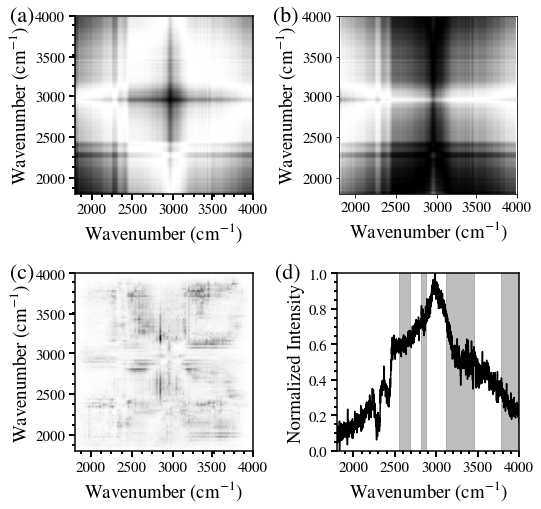

In [86]:
rcparams(0.75)
plot_saliency(gradSum, dataSum, oneDSum, plastic_type=plastic_type, window=[(2550, 2680), (2810, 2880), (3120, 3450), (4710, 3780)])

[2548 2592 2636 2658 2680 2812 2856 2878 3120 3142 3164 3186 3208 3230
 3252 3274 3296 3318 3340 3362 3384 3406 3428 3450 3714 3736 3758 3780]


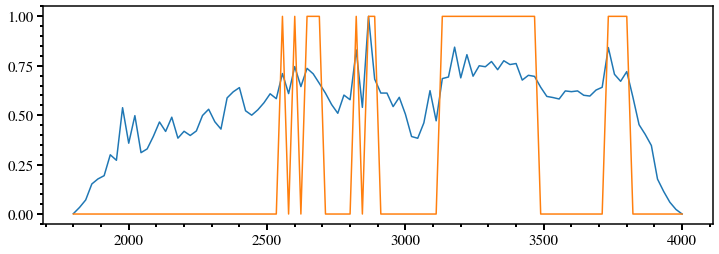

In [85]:
grad_1d = np.flipud(np.fliplr(gradSum)).mean(axis=1) + np.flipud(np.fliplr(gradSum)).mean(axis=0)
grad_1d = skp.minmax_scale(grad_1d)
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(np.linspace(1800, 4000, 100), grad_1d)
grad = np.zeros_like(grad_1d)
grad[grad_1d >= 0.65] = 1
print(np.where(grad_1d >= 0.65)[0]*22+1800)
ax.plot(np.linspace(1800, 4000, 100), grad)
format_axis(ax)

### ABS/PC

In [87]:
%%time
plastic_type = 1
gradSum, dataSum, oneDSum = saliency(plastic_type)

CPU times: user 32min 36s, sys: 1min 26s, total: 34min 3s
Wall time: 4min 31s


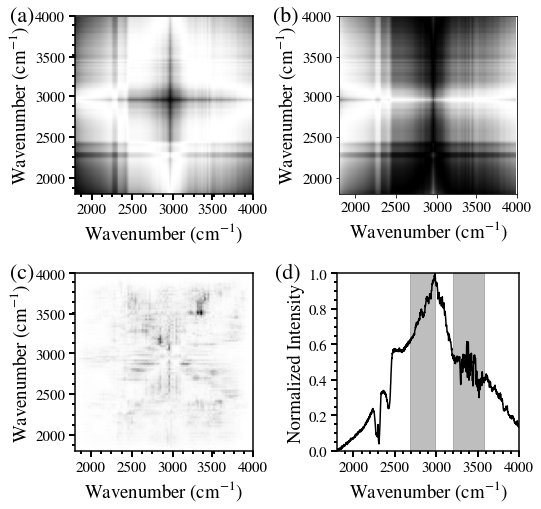

In [91]:
plot_saliency(gradSum, dataSum, oneDSum, plastic_type=plastic_type, window=[(2680, 2990), (3200, 3580)])

[2548 2636 2680 2702 2724 2746 2768 2790 2812 2834 2856 2878 2922 2944
 2966 2988 3208 3230 3252 3274 3296 3318 3340 3362 3384 3406 3428 3450
 3472 3494 3516 3538 3582]


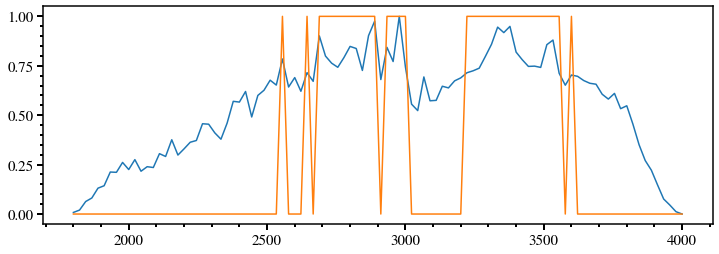

In [90]:
grad_1d = np.flipud(np.fliplr(gradSum)).mean(axis=1) + np.flipud(np.fliplr(gradSum)).mean(axis=0)
grad_1d = skp.minmax_scale(grad_1d)
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(np.linspace(1800, 4000, 100), grad_1d)
grad = np.zeros_like(grad_1d)
grad[grad_1d >= 0.7] = 1
print(np.where(grad_1d >= 0.7)[0]*22+1800)
ax.plot(np.linspace(1800, 4000, 100), grad)
format_axis(ax)

### HIPS

In [92]:
%%time
plastic_type = 2
gradSum, dataSum, oneDSum = saliency(plastic_type)

CPU times: user 31min 41s, sys: 1min 27s, total: 33min 8s
Wall time: 4min 17s


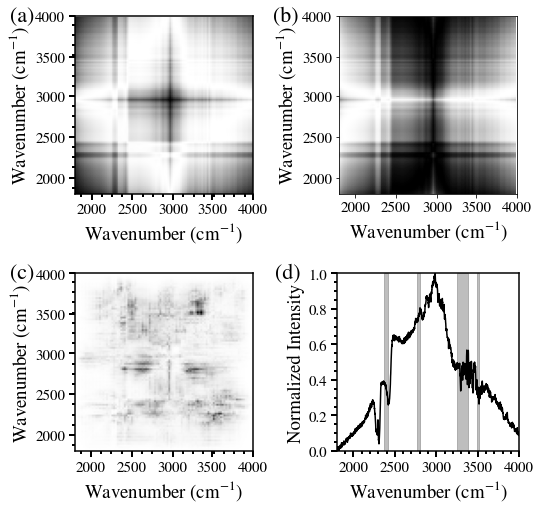

In [94]:
plot_saliency(gradSum, dataSum, oneDSum, plastic_type=plastic_type, window=[(2370, 2420), (2770, 2800), (3250, 3380), (3490, 3520)])

[2262 2372 2394 2416 2768 2790 2812 2834 2878 2966 3252 3274 3296 3318
 3340 3362 3384 3494 3516 3604]


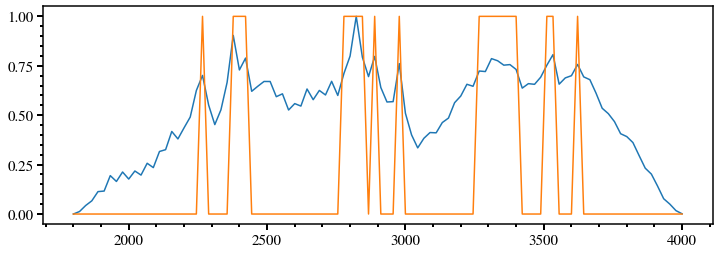

In [93]:
grad_1d = np.flipud(np.fliplr(gradSum)).mean(axis=1) + np.flipud(np.fliplr(gradSum)).mean(axis=0)
grad_1d = skp.minmax_scale(grad_1d)
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(np.linspace(1800, 4000, 100), grad_1d)
grad = np.zeros_like(grad_1d)
grad[grad_1d >= 0.7] = 1
print(np.where(grad_1d >= 0.7)[0]*22+1800)
ax.plot(np.linspace(1800, 4000, 100), grad)
format_axis(ax)

### PA12

In [95]:
%%time
plastic_type = 3
gradSum, dataSum, oneDSum = saliency(plastic_type)

CPU times: user 31min 45s, sys: 1min 28s, total: 33min 13s
Wall time: 4min 9s


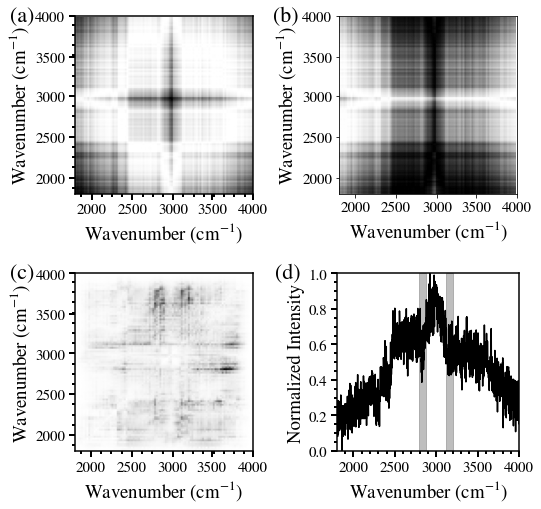

In [98]:
plot_saliency(gradSum, dataSum, oneDSum, plastic_type=plastic_type, window=[(2790, 2880), (3120, 3200)])

[2790 2812 2878 3120 3142 3208 3626]


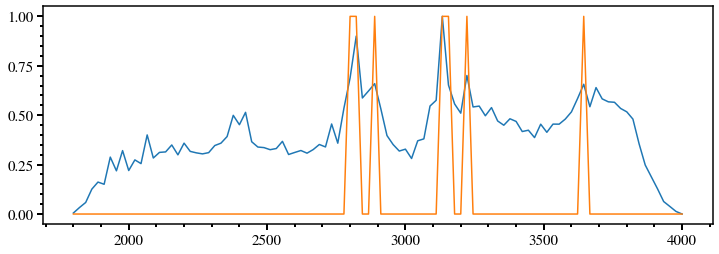

In [97]:
grad_1d = np.flipud(np.fliplr(gradSum)).mean(axis=1) + np.flipud(np.fliplr(gradSum)).mean(axis=0)
grad_1d = skp.minmax_scale(grad_1d)
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(np.linspace(1800, 4000, 100), grad_1d)
grad = np.zeros_like(grad_1d)
grad[grad_1d >= 0.65] = 1
print(np.where(grad_1d >= 0.65)[0]*22+1800)
ax.plot(np.linspace(1800, 4000, 100), grad)
format_axis(ax)

### PE

In [99]:
%%time
plastic_type = 4
gradSum, dataSum, oneDSum = saliency(plastic_type)

CPU times: user 31min 45s, sys: 1min 31s, total: 33min 17s
Wall time: 4min 21s


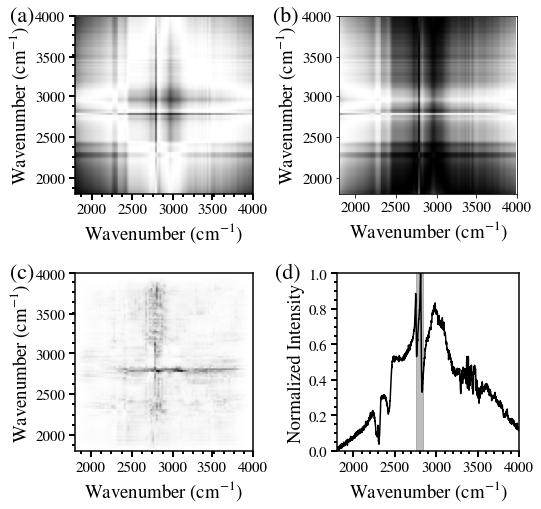

In [105]:
plot_saliency(gradSum, dataSum, oneDSum, plastic_type=plastic_type, window=[(2760, 2840)])

[2768 2790 2812 2834]


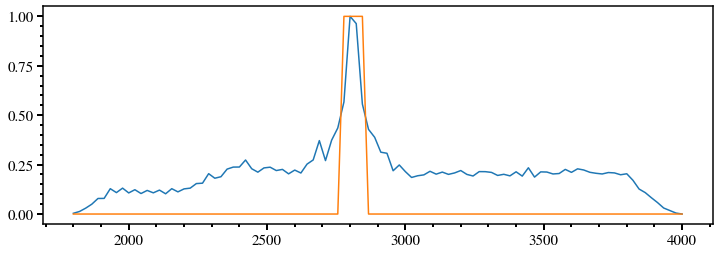

In [104]:
grad_1d = np.flipud(np.fliplr(gradSum)).mean(axis=1) + np.flipud(np.fliplr(gradSum)).mean(axis=0)
grad_1d = skp.minmax_scale(grad_1d)
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(np.linspace(1800, 4000, 100), grad_1d)
grad = np.zeros_like(grad_1d)
grad[grad_1d >= 0.5] = 1
print(np.where(grad_1d >= 0.5)[0]*22+1800)
ax.plot(np.linspace(1800, 4000, 100), grad)
format_axis(ax)

### PET

In [106]:
%%time
plastic_type = 5
gradSum, dataSum, oneDSum = saliency(plastic_type)

CPU times: user 30min 17s, sys: 1min 22s, total: 31min 40s
Wall time: 3min 47s


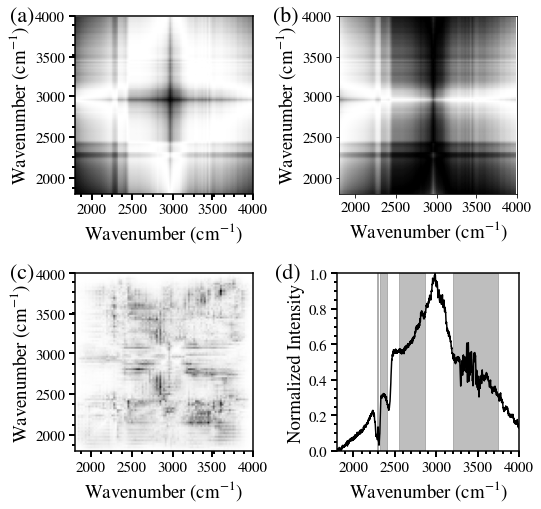

In [109]:
plot_saliency(gradSum, dataSum, oneDSum, plastic_type=plastic_type, window=[(2280, 2290), (2410, 2320), (2550, 2860), (3200, 3740)])

[2284 2394 2416 2548 2592 2636 2680 2724 2746 2768 2790 2812 2856 3208
 3252 3274 3362 3428 3450 3472 3494 3516 3560 3582 3604 3626 3670 3736]


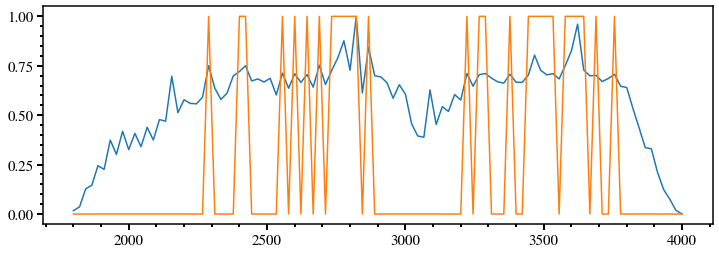

In [108]:
grad_1d = np.flipud(np.fliplr(gradSum)).mean(axis=1) + np.flipud(np.fliplr(gradSum)).mean(axis=0)
grad_1d = skp.minmax_scale(grad_1d)
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(np.linspace(1800, 4000, 100), grad_1d)
grad = np.zeros_like(grad_1d)
grad[grad_1d >= 0.7] = 1
print(np.where(grad_1d >= 0.7)[0]*22+1800)
ax.plot(np.linspace(1800, 4000, 100), grad)
format_axis(ax)

### PLA

In [110]:
%%time
plastic_type = 6
gradSum, dataSum, oneDSum = saliency(plastic_type)

CPU times: user 31min 33s, sys: 1min 31s, total: 33min 5s
Wall time: 4min 16s


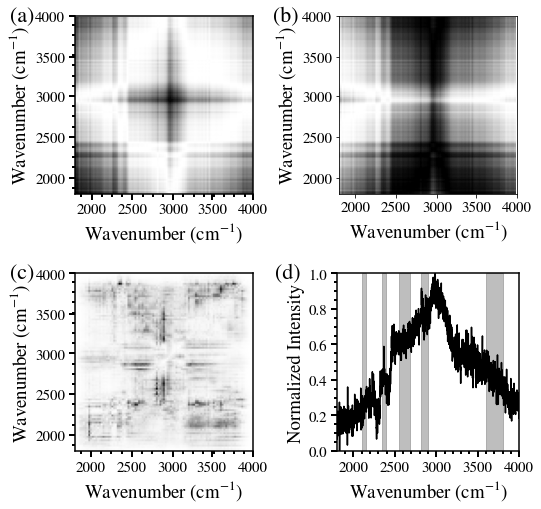

In [115]:
plot_saliency(gradSum, dataSum, oneDSum, plastic_type=plastic_type, window=[(2100, 2150), (2350, 2390), (2550, 2680), (2810, 2900), (3600, 3800)])

[1976 2108 2152 2350 2372 2394 2548 2592 2636 2680 2812 2856 2878 2900
 3296 3604 3670 3692 3714 3736 3758 3780 3802]


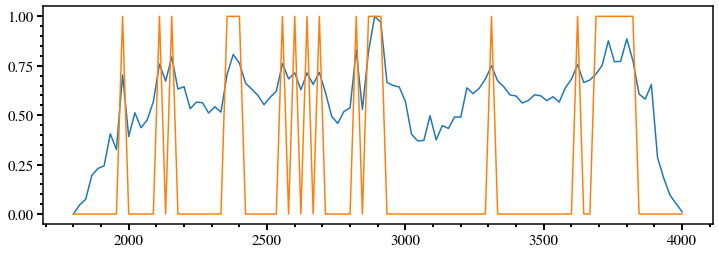

In [113]:
grad_1d = np.flipud(np.fliplr(gradSum)).mean(axis=1) + np.flipud(np.fliplr(gradSum)).mean(axis=0)
grad_1d = skp.minmax_scale(grad_1d)
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(np.linspace(1800, 4000, 100), grad_1d)
grad = np.zeros_like(grad_1d)
grad[grad_1d >= 0.70] = 1
print(np.where(grad_1d >= 0.70)[0]*22+1800)
ax.plot(np.linspace(1800, 4000, 100), grad)
format_axis(ax)

### PMMA

In [116]:
%%time
plastic_type = 7
gradSum, dataSum, oneDSum = saliency(plastic_type)

CPU times: user 30min 54s, sys: 1min 34s, total: 32min 29s
Wall time: 4min 5s


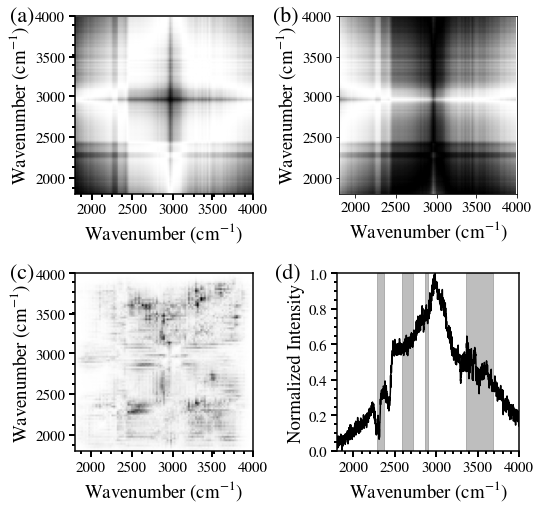

In [118]:
plot_saliency(gradSum, dataSum, oneDSum, plastic_type=plastic_type, window=[(2280, 2370), (2590, 2720), (2860, 2900), (3360, 3690)])

[2284 2372 2592 2614 2658 2680 2724 2856 2878 2900 3208 3296 3318 3362
 3384 3406 3428 3450 3472 3494 3516 3538 3560 3582 3604 3626 3648 3670
 3692]


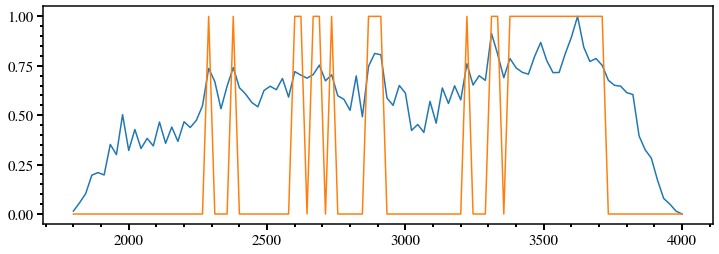

In [117]:
grad_1d = np.flipud(np.fliplr(gradSum)).mean(axis=1) + np.flipud(np.fliplr(gradSum)).mean(axis=0)
grad_1d = skp.minmax_scale(grad_1d)
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(np.linspace(1800, 4000, 100), grad_1d)
grad = np.zeros_like(grad_1d)
grad[grad_1d >= 0.70] = 1
print(np.where(grad_1d >= 0.70)[0]*22+1800)
ax.plot(np.linspace(1800, 4000, 100), grad)
format_axis(ax)

### POM

In [119]:
%%time
plastic_type = 8
gradSum, dataSum, oneDSum = saliency(plastic_type)

CPU times: user 30min 44s, sys: 1min 31s, total: 32min 15s
Wall time: 4min 8s


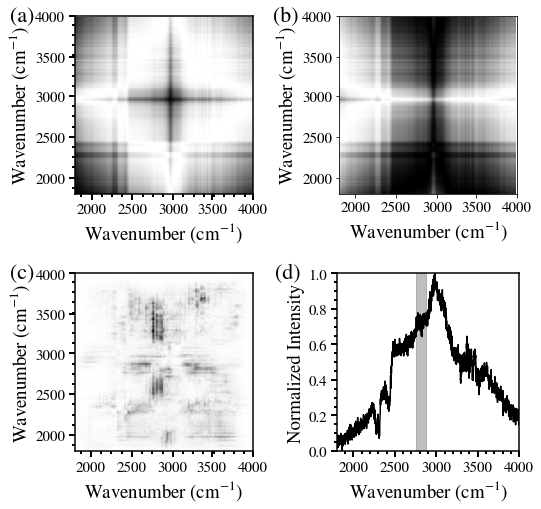

In [121]:
plot_saliency(gradSum, dataSum, oneDSum, plastic_type=plastic_type, window=[(2760, 2880)])

[2768 2812 2856 2878]


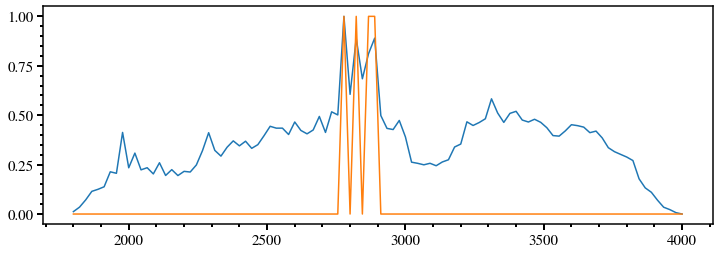

In [120]:
grad_1d = np.flipud(np.fliplr(gradSum)).mean(axis=1) + np.flipud(np.fliplr(gradSum)).mean(axis=0)
grad_1d = skp.minmax_scale(grad_1d)
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(np.linspace(1800, 4000, 100), grad_1d)
grad = np.zeros_like(grad_1d)
grad[grad_1d >= 0.70] = 1
print(np.where(grad_1d >= 0.70)[0]*22+1800)
ax.plot(np.linspace(1800, 4000, 100), grad)
format_axis(ax)

### PP/PE/PS

In [122]:
%%time
plastic_type = 9
gradSum, dataSum, oneDSum = saliency(plastic_type)

CPU times: user 30min 8s, sys: 1min 20s, total: 31min 28s
Wall time: 3min 39s


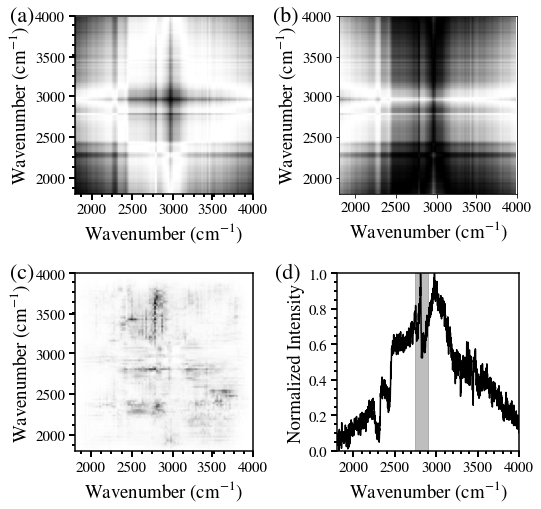

In [126]:
plot_saliency(gradSum, dataSum, oneDSum, plastic_type=plastic_type, window=[(2740, 2900)])

[2372 2548 2746 2768 2790 2812 2834 2856 2878 3428]


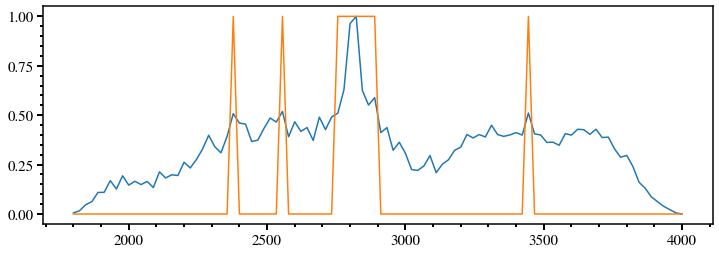

In [125]:
grad_1d = np.flipud(np.fliplr(gradSum)).mean(axis=1) + np.flipud(np.fliplr(gradSum)).mean(axis=0)
grad_1d = skp.minmax_scale(grad_1d)
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(np.linspace(1800, 4000, 100), grad_1d)
grad = np.zeros_like(grad_1d)
grad[grad_1d >= 0.5] = 1
print(np.where(grad_1d >= 0.50)[0]*22+1800)
ax.plot(np.linspace(1800, 4000, 100), grad)
format_axis(ax)

### PP

In [127]:
%%time
plastic_type = 10
gradSum, dataSum, oneDSum = saliency(plastic_type)

CPU times: user 30min 21s, sys: 1min 24s, total: 31min 46s
Wall time: 3min 44s


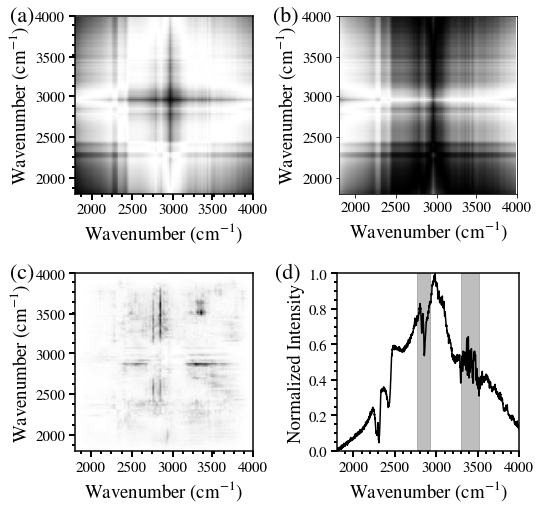

In [130]:
plot_saliency(gradSum, dataSum, oneDSum, plastic_type=plastic_type, window=[(2770, 2920), (3300, 3520)])

[2768 2812 2834 2856 2878 2922 3296 3318 3340 3362 3384 3494 3516]


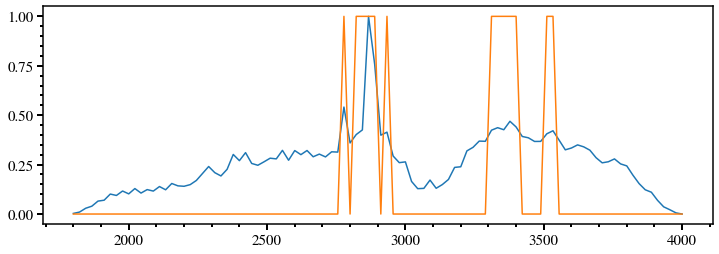

In [129]:
grad_1d = np.flipud(np.fliplr(gradSum)).mean(axis=1) + np.flipud(np.fliplr(gradSum)).mean(axis=0)
grad_1d = skp.minmax_scale(grad_1d)
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(np.linspace(1800, 4000, 100), grad_1d)
grad = np.zeros_like(grad_1d)
grad[grad_1d >= 0.4] = 1
print(np.where(grad_1d >= 0.40)[0]*22+1800)
ax.plot(np.linspace(1800, 4000, 100), grad)
format_axis(ax)

### PS

In [131]:
%%time
plastic_type = 11
gradSum, dataSum, oneDSum = saliency(plastic_type)

CPU times: user 29min 36s, sys: 1min 20s, total: 30min 56s
Wall time: 3min 34s


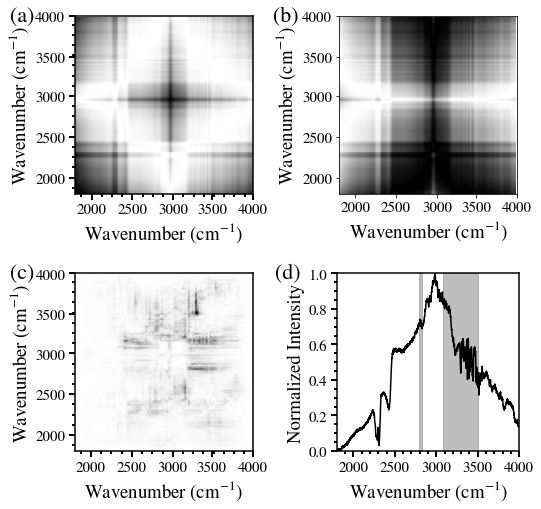

In [133]:
plot_saliency(gradSum, dataSum, oneDSum, plastic_type=plastic_type, window=[(2790, 2830), (3080, 3500)])

[2790 2812 2834 3076 3120 3142 3164 3186 3208 3230 3252 3274 3296 3318
 3340 3362 3428 3494]


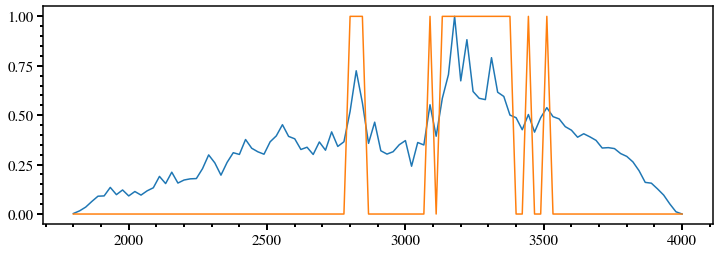

In [132]:
grad_1d = np.flipud(np.fliplr(gradSum)).mean(axis=1) + np.flipud(np.fliplr(gradSum)).mean(axis=0)
grad_1d = skp.minmax_scale(grad_1d)
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(np.linspace(1800, 4000, 100), grad_1d)
grad = np.zeros_like(grad_1d)
grad[grad_1d >= 0.5] = 1
print(np.where(grad_1d >= 0.50)[0]*22+1800)
ax.plot(np.linspace(1800, 4000, 100), grad)
format_axis(ax)

### PVC

In [134]:
%%time
plastic_type = 12
gradSum, dataSum, oneDSum = saliency(plastic_type)

CPU times: user 29min 25s, sys: 1min 20s, total: 30min 45s
Wall time: 3min 35s


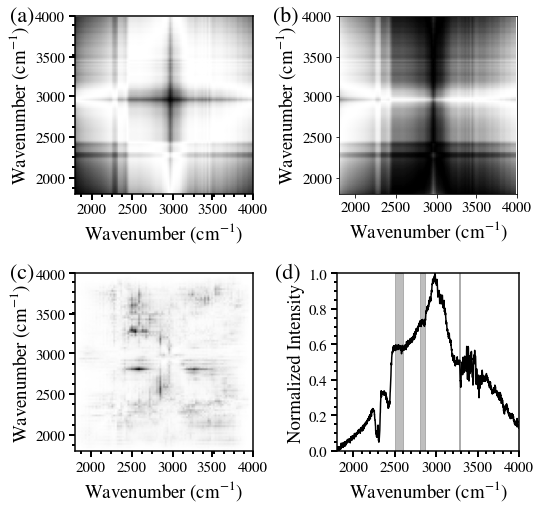

In [137]:
plot_saliency(gradSum, dataSum, oneDSum, plastic_type=plastic_type, window=[(2500, 2600), (2800, 2860), (3270, 3290)])

[2504 2548 2592 2812 2834 2856 3274 3296]


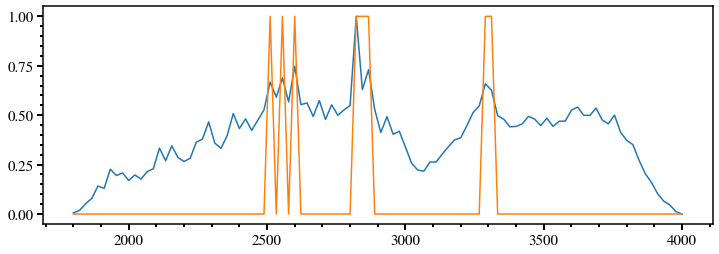

In [136]:
grad_1d = np.flipud(np.fliplr(gradSum)).mean(axis=1) + np.flipud(np.fliplr(gradSum)).mean(axis=0)
grad_1d = skp.minmax_scale(grad_1d)
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(np.linspace(1800, 4000, 100), grad_1d)
grad = np.zeros_like(grad_1d)
grad[grad_1d >= 0.6] = 1
print(np.where(grad_1d >= 0.60)[0]*22+1800)
ax.plot(np.linspace(1800, 4000, 100), grad)
format_axis(ax)

### PC

In [138]:
%%time
plastic_type = 13
gradSum, dataSum, oneDSum = saliency(plastic_type)

CPU times: user 29min 27s, sys: 1min 23s, total: 30min 50s
Wall time: 3min 39s


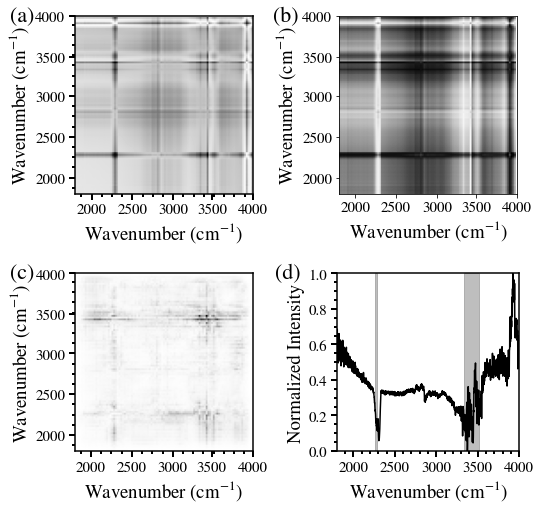

In [141]:
plot_saliency(gradSum, dataSum, oneDSum, plastic_type=plastic_type, window=[(2260, 2280), (3340, 3520)])

[2262 2284 3340 3384 3428 3450 3472 3494 3516]


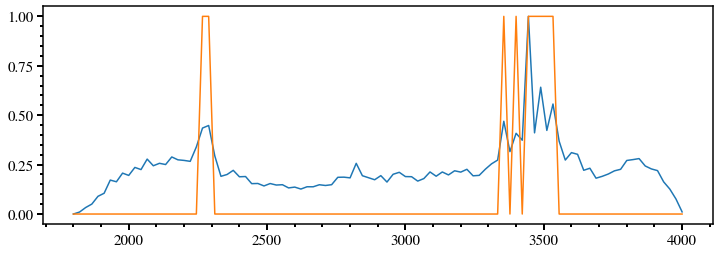

In [140]:
grad_1d = np.flipud(np.fliplr(gradSum)).mean(axis=1) + np.flipud(np.fliplr(gradSum)).mean(axis=0)
grad_1d = skp.minmax_scale(grad_1d)
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(np.linspace(1800, 4000, 100), grad_1d)
grad = np.zeros_like(grad_1d)
grad[grad_1d >= 0.4] = 1
print(np.where(grad_1d >= 0.4)[0]*22+1800)
ax.plot(np.linspace(1800, 4000, 100), grad)
format_axis(ax)

### Other machine learning methods

In [9]:
osname = platform.system()
if osname == 'Darwin':
    data_dir = r'/Users/sjiang87/plastic/data/'
    weight_dir = r'/Users/sjiang87/plastic/weights/2nd/'
    result_dir = r'/Users/sjiang87/machinelearning2/plastic/result/'
elif osname == 'Windows':
    data_dir = r'D:/plastic/data/'
    weight_dir = r'D:/plastic/weights/2nd/'
    result_dir = r'D:/machinelearning2/plastic/result/'
elif osname == 'Linux':
    data_dir = r'./'
    weight_dir = r'./'
    result_dir = r'./'
    


In [8]:
def find_hyperparam(x, y, clf, parameters, scoring=None, show=True):
    clf = skms.GridSearchCV(clf, parameters, scoring=scoring)
    clf.fit(x, y)
    if show:
        print([clf.best_params_, clf.best_score_])
    return clf

In [7]:
def k_fold(k=1):
    with open(data_dir + 'fast_with_pc.pickle', 'rb') as handle:
        x = pickle.load(handle)
        y = pickle.load(handle)
    # scale the 1D CNN data to be between 0 and 1.
    x = skp.minmax_scale(x, axis=1)
    # shuffle x and y with a fixed random seed.
    x = np.random.RandomState(0).permutation(x)
    y = np.random.RandomState(0).permutation(y)
    # define stratified 5-fold cross-validation
    skf = skms.StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    # if i = k, then we stop
    i = 0
    for train_index, test_index in skf.split(x, y):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        i += 1
        if i == k:
            print(f'This is fold {i}.')
            break
    return x_train, x_test, y_train, y_test

### SVM

In [22]:
%%time
from sklearn.svm import SVC
x_train, x_test, y_train, y_test = k_fold(k=1)
clf = find_hyperparam(x_train, y_train, SVC(decision_function_shape='ovr'), {'C': [i for i in np.arange(1, 10, 2)]}, scoring=None, show=True)

In [9]:
from sklearn.svm import SVC
acc = []
for k in range(1, 6):
    x_train, x_test, y_train, y_test = k_fold(k)
    clf = SVC(decision_function_shape='ovr', C=5)
    clf.fit(x_train, y_train)
    t0 = timer()
    y_pred = clf.predict(x_test)
    t1 = timer()
    print(f'{t1-t0:0.3f}')
    acc_temp = skm.accuracy_score(y_test, y_pred)
    acc.append(acc_temp)

This is fold 1.
100.776
This is fold 2.
100.764
This is fold 3.
100.753
This is fold 4.
99.803
This is fold 5.
101.082


In [10]:
time = np.array([100.776, 100.764, 100.753, 99.803, 101.082]) / 14000 * 1000 * 1000
print(f'Time per spectrum: {np.mean(time):0.4f} +/- {np.std(time)}um.')
print(f'Accuracy: {np.mean(acc):0.4f} +/- {np.std(acc):0.4f}')

Time per spectrum: 7188.2571 +/- 31.011472531491048um.
Accuracy: 0.9999 +/- 0.0001


### Random forests

In [ ]:
%%time
from sklearn.ensemble import RandomForestClassifier
x_train, x_test, y_train, y_test = k_fold(k=1)
clf = find_hyperparam(x_train, y_train, RandomForestClassifier(random_state=0, max_features='sqrt', n_jobs=-1), {'n_estimators': [i for i in np.arange(10, 110, 10)]}, scoring=None, show=True)

This is fold 1.


In [9]:
from sklearn.ensemble import RandomForestClassifier
acc = []
for k in range(1, 6):
    x_train, x_test, y_train, y_test = k_fold(k)
    clf = RandomForestClassifier(random_state=0, max_features='sqrt', n_estimators=100, n_jobs=-1)
    clf.fit(x_train, y_train)
    t0 = timer()
    y_pred = clf.predict(x_test)
    t1 = timer()
    print(f'{t1-t0:0.3f}')
    acc_temp = skm.accuracy_score(y_test, y_pred)
    acc.append(acc_temp)

This is fold 1.
0.179
This is fold 2.
0.180
This is fold 3.
0.175
This is fold 4.
0.177
This is fold 5.
0.200


In [11]:
time = np.array([0.179, 0.180, 0.175, 0.177, 0.200]) / 14000 * 1000 * 1000
print(f'Time per spectrum: {np.mean(time):0.4f} +/- {np.std(time)}um.')
print(f'Accuracy: {np.mean(acc):0.4f} +/- {np.std(acc):0.4f}')

Time per spectrum: 13.0143 +/- 0.6474439539214099um.
Accuracy: 0.9869 +/- 0.0010


### KNN

In [14]:
%%time
from sklearn.neighbors import KNeighborsClassifier
x_train, x_test, y_train, y_test = k_fold(k=1)
clf = find_hyperparam(x_train, y_train, KNeighborsClassifier(n_jobs=-1), {'n_neighbors': [i for i in np.arange(10, 20, 1)]}, scoring=None, show=True)

This is fold 1.
[{'n_neighbors': 19}, 0.8217857142857143]
Wall time: 17min 36s


In [15]:
from sklearn.neighbors import KNeighborsClassifier
acc = []
for k in range(1, 6):
    x_train, x_test, y_train, y_test = k_fold(k)
    clf = KNeighborsClassifier(n_neighbors=19)
    clf.fit(x_train, y_train)
    t0 = timer()
    y_pred = clf.predict(x_test)
    t1 = timer()
    print(f'{t1-t0:0.3f}')
    acc_temp = skm.accuracy_score(y_test, y_pred)
    acc.append(acc_temp)

This is fold 1.
21.816
This is fold 2.
21.748
This is fold 3.
21.800
This is fold 4.
21.252
This is fold 5.
21.519


In [16]:
time = np.array([21.816, 21.748, 21.800, 21.252, 21.519]) / 14000 * 1000 * 1000
print(f'Time per spectrum: {np.mean(time):0.4f} +/- {np.std(time)}um.')
print(f'Accuracy: {np.mean(acc):0.4f} +/- {np.std(acc):0.4f}')

Time per spectrum: 1544.7857 +/- 15.405405889240534um.
Accuracy: 0.8208 +/- 0.0010
